In [1]:
import sys
import json
import numpy as np
from operator import add
from math import sqrt
# from pyspark import SparkContext
# sc = SparkContext(appName="ParseEventLog")
from pyspark.sql import SQLContext
import copy
from parselogs import *
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random

In [2]:
pca_log_dir = '/project/projectdirs/paralleldb/spark/benchmarks/pca_climate/large-scale-climate/eventLogs/'
nmf_log_dir = '/project/projectdirs/paralleldb/spark/benchmarks/nmf/nmfspark/eventLogs/'
cx_log_dir = '/project/projectdirs/paralleldb/spark/benchmarks/cx/event_logs/'

In [3]:
pca_dic = {100: 'app-20160407025819-0000', 300: 'app-20160407032107-0000', 500:'app-20160407034211-0000', 1600: 'app-20160407050845-0000', 
           'oth': 'app-20160331051335-0000'}
pca_dict = {k: pca_log_dir + v for k,v in pca_dic.iteritems()} 
nmf_dic = {100: 'app-20160406163133-0000',50: 'app-20160406162858-0000', 300: 'app-20160406164522-0000' }
nmf_dict = {k: nmf_log_dir + v for k,v in nmf_dic.iteritems()}
cx_dic = {60:'app-20160307235013-0000', 100: 'app-20160331152132-0000', 300: 'app-20160310010018-0000'}
cx_dict = {k: cx_log_dir + v for k,v in cx_dic.iteritems()}
algo_name='PCA'

In [4]:
pca_pds = [ParseLogs(sc,pca_dict[k] , algo='pca') for k in [100,300,500]]

In [6]:
cx_pds = [ParseLogs(sc,cx_dict[k] , algo='cx') for k in [60,100,300]]

In [35]:
nmf_pds = [ParseLogs(sc,nmf_dict[k] , algo='nmf') for k in [50,100,300]]

In [4]:
oth_pds = [ParseLogs(sc,pca_dict[k] , algo='pca') for k in ['oth']]

In [3]:
big_run_pd = ParseLogs(sc, pca_dict[1600] , algo='pca')

In [4]:
pds = [big_run_pd]

#Plot Summary Using Max/Min/Median **TASK** in each Stage
ie: Approximating the running time distribution by summing up the min,median,mean,max tasks per stage, respectively

In [17]:
summary_ordered_keys = copy.deepcopy(ordered_keys)
offset=0
colors_dict = dict(zip(summary_ordered_keys, colors.cnames.keys()[offset:offset+len(summary_ordered_keys)]))

In [11]:
key = "Time To Finish From Stage Start"

In [5]:
cx_means = {pd.num_execs: pd.get_summary_tasks_for_mpl('mean', key) for pd in cx_pds}

In [16]:
nmf_means = {pd.num_execs: pd.get_summary_tasks_for_mpl('mean', key) for pd in nmf_pds}

In [10]:
oth_means ={pd.num_execs: pd.get_summary_tasks_for_mpl('mean', key) for pd in oth_pds}

In [12]:
pca_means = {pd.num_execs: pd.get_summary_tasks_for_mpl('mean', key) for pd in pca_pds}

In [7]:
pca_hero_means = {pd.num_execs: pd.get_summary_tasks_for_mpl('mean', key) for pd in [big_run_pd]}
pca_hero_maxes = {pd.num_execs: pd.get_summary_tasks_for_mpl('max', key) for pd in [big_run_pd]}


In [230]:
#calc without IO time
[ (pd.run_time - nmf_means[pd.num_execs]['Parallel HDF5 Read'] )/ 1000. for pd in nmf_pds]
[ (pd.run_time - pca_means[pd.num_execs]['Parallel HDF5 Read'] )/ 1000. for pd in pca_pds]
[ (pd.run_time - pca_hero_means[pd.num_execs]['Parallel HDF5 Read'] )/ 1000. for pd in [big_run_pd]]

[3990.975]

In [12]:
colores = [(0.2, 1, 0.5), (1, 0.4, 0.4), (1, 1, 0), (0, 0.6, 1)]

In [13]:
pca_mpi_keys = ["Parallel HDF5 Read", "Gram Matrix-Vector Product", "A*V Product", "SVD A*V"]
nmf_mpi_keys = ["Parallel HDF5 Read", "Transpose", "TSQR", "XRAY"]
color_key_dict = {'pca': dict(zip(pca_mpi_keys,colores)), 'nmf': dict(zip(nmf_mpi_keys, colores))}

In [67]:
sum([means[0][k] for k in means[0].keys() if k not in ["JVM GC Time",'Time To Finish From Stage Start']])

4175329.44703125

In [146]:
items_to_plot =dict(zip([50,100,300], means))#[a[0] for a in [mins, means]] #[mins_for_mpl, medians_for_mpl, means_for_mpl, maxes_for_mpl]

In [10]:
a = range(30)
[a.remove(noog) for noog in range(5)]
print a

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [19]:
isinstance?

In [29]:
class Plotter(object):
    def __init__(self, dict_of_pd_objects):
        self.dict_of_pd_objects = dict_of_pd_objects
        self.offset = 0
        self.default_ordered_keys = {'start':['Driver Compute Time','Task Start Delay', 'Executor Deserialize Time', 'Scheduler Delay'], 
                                     'end':['Time Waiting Until Stage End']}

    def plot_runtime_distribution(self,sum_stat_fxn='mean', fold_task_overheads=True, ordered_keys=None):
        '''assume items to plot is dict of dicts, where keys are concurrency and values are dicts with runtime dist'''
        key = "Time To Finish From Stage Start"
        items_to_plot = {k: pd.get_summary_tasks_for_mpl(sum_stat_fxn, key, fold_task_overheads) 
                         for k,pd in self.dict_of_pd_objects.iteritems()}
        
        ordered_keys = self.process_ordered_keys(ordered_keys, items_to_plot)


        colors_dict = dict(zip(ordered_keys, colors.cnames.keys()[self.offset:self.offset+len(ordered_keys)]))
        self._plot_bar_plot(items_to_plot, ordered_keys, colors_dict)

 
    def process_ordered_keys(self, ordered_keys, items_to_plot):
        if ordered_keys is None:
            ordered_keys = self.create_ordered_keys(items_to_plot)
            [ordered_keys.remove(k) for k in self.default_ordered_keys['start'] + self.default_ordered_keys['end']]
            ordered_keys = self.default_ordered_keys['start'] + ordered_keys + self.default_ordered_keys['end']
        
        elif isinstance(ordered_keys, dict):
            '''if user specifies keys they want in start, middle or end, then we combine this ordering with
            default ordering for any of start middle and end they did not specify and then combine them along
            with what is left over'''
            
            o_keys = self.create_ordered_keys(items_to_plot)
            new_ordered_keys = []
            for order_k in ['start', 'middle', 'end']:
                if order_k not in ordered_keys:
                    ordered_keys[order_k] = self.default_ordered_keys[order_k]
            
            [o_keys.remove(key) for k in  ['start', 'middle', 'end'] for key in ordered_keys[k] ]
            ordered_keys = ordered_keys['start'] + ordered_keys['middle'] + o_keys + ordered_keys['end']
        else:
            pass #user specifies exact ordering and which keys they want so no changes are made
                    
        return ordered_keys
            
    def create_ordered_keys(self, items_to_plot):
        ordered_keys = []
        for key_l in [it.keys() for it in items_to_plot.values()]:
            ordered_keys.extend(key_l)
        ordered_keys = list(set(ordered_keys))
        return ordered_keys
        
    def _plot_bar_plot(self,items_to_plot, ordered_keys, colors_dict):

        plt.rcParams['figure.figsize'] = (20.0, 16.0)
        algo = "pca"#pds[0].algo

        bottom = len(items_to_plot.values()) *[0]
        colors_ = colors.cnames.keys()
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ind = np.arange(len(bottom))
        width = 0.7
        label_table = {}
        items_to_plot_v = [items_to_plot[k] for k in sorted(items_to_plot.keys())]
        for i,k in enumerate(ordered_keys):
            for j, it in enumerate(items_to_plot_v):
                if k not in it: #or k == "Time Waiting Until Stage End":
                    continue

                color = colors_dict[k]

                if k not in label_table:
                    label_table[k] = 0
                    label = k
                else:
                    label = None

                val = it[k] / 1000.
                bar = ax1.bar(ind[j], val,
                                    width=width,color=color, bottom=bottom[j],
                                     ecolor='k',label=label)

                bottom[j] = bottom[j] + val

        ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5, prop={'size': 15})
        plt.ylabel('Time(s)', fontsize=30)
        plt.xlabel('Nodes', fontsize=30)
        plt.yticks(fontsize=30)
        ticks = sorted(items_to_plot.keys())
        plt.xticks(ind + width/2.,ticks , fontsize=30)
        plt.title("%s Run Time "% ( algo.upper()), fontsize=30)
        plt.show()
        return plt


In [30]:
keyed_pca_pds = dict(zip([100,300,500],pca_pds))

In [31]:
pt = Plotter(keyed_pca_pds)

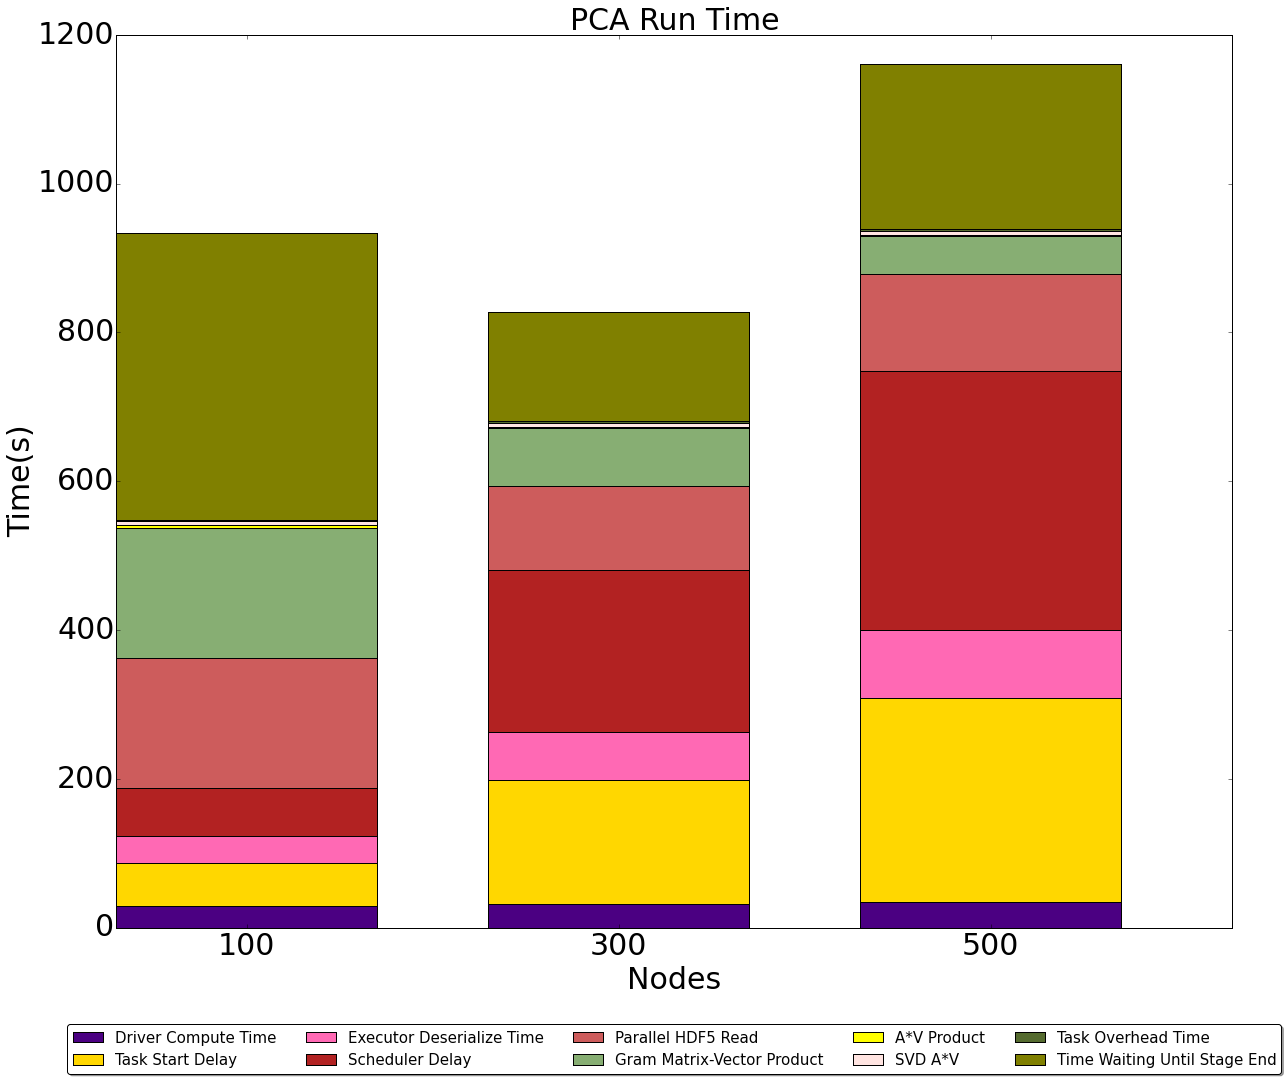

In [32]:
pt.plot_runtime_distribution(
    ordered_keys={'middle': ['Parallel HDF5 Read', 'Gram Matrix-Vector Product', 'A*V Product', 'SVD A*V']})

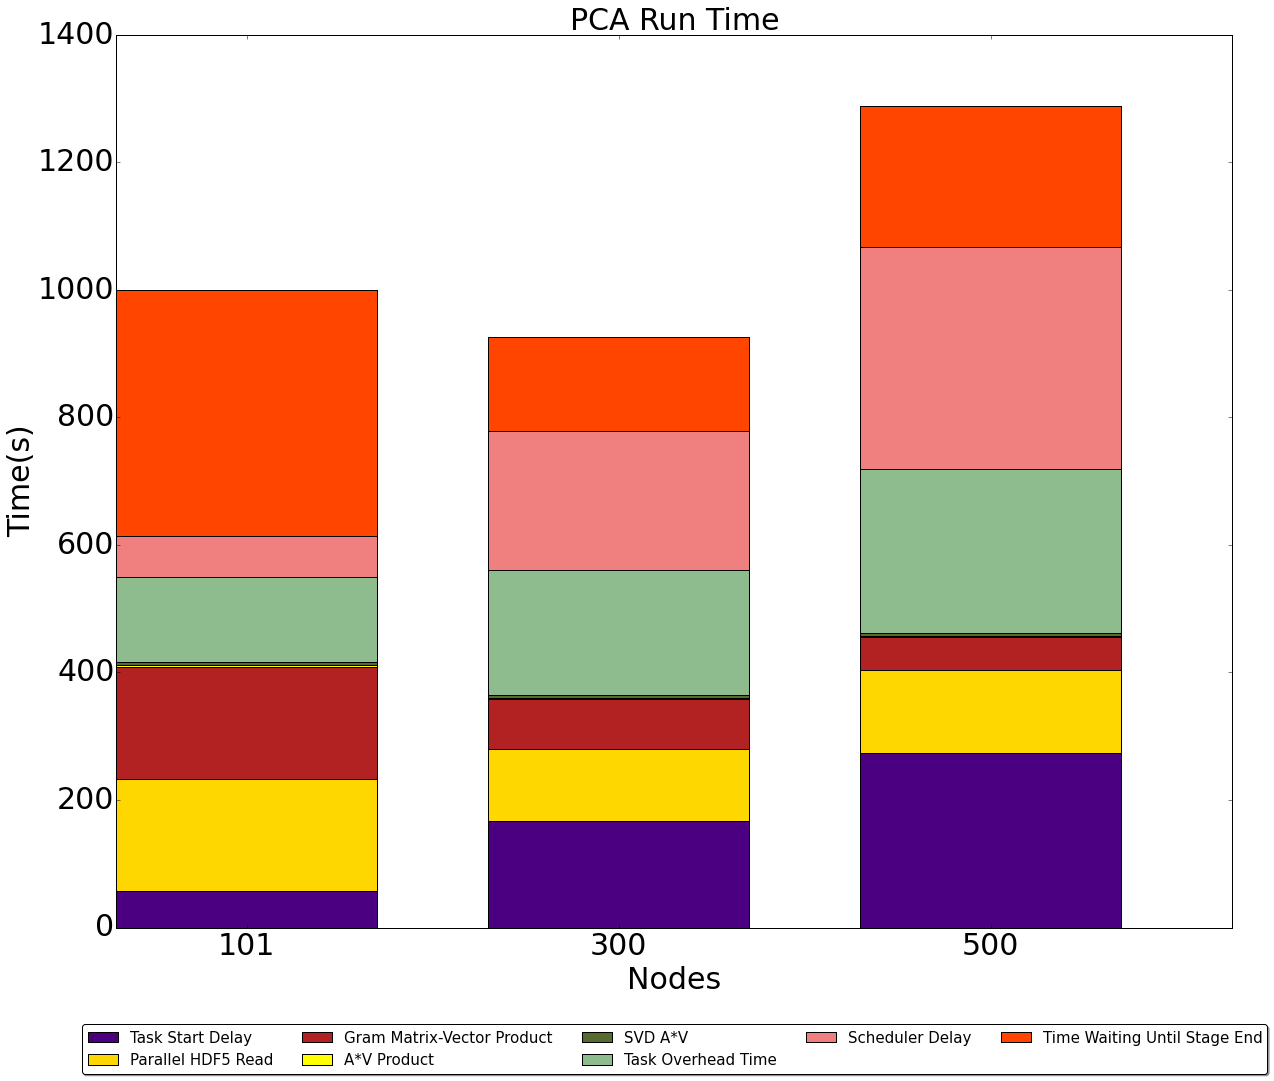

<module 'matplotlib.pyplot' from '/usr/common/software/python/matplotlib/1.4.3/lib/python/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/pyplot.pyc'>

In [18]:
plot_runtime_distribution(pca_means, summary_ordered_keys)

In [27]:
a=[[1,2],[3,4]]
b = []
for lis in a:
    b.extend(lis)
print b

[1, 2, 3, 4]


In [28]:
d = {'b':3, 'c':2, 'a':5, 'x':4}

['a', 'x', 'c', 'b']

#Special Plot For Hero Run

In [25]:
pds = [big_run_pd]

In [59]:
mpi_times= {'Parallel HDF5 Read': 69.44,
'Gram Matrix-Vector Product': 20.12,
'A*V Product': 43.64,
'SVD A*V': 25.96}

In [27]:
summary_ordered_keys = copy.deepcopy(ordered_keys)
summary_ordered_keys.insert(0,'Driver Compute Time')
summary_ordered_keys.insert(0,'JVM GC Time')

In [28]:
key = "Time To Finish From Stage Start"

In [29]:
means = [pd.get_summary_tasks_for_mpl('mean', key) for pd in pds]

In [33]:
items_to_plot = [{k:v} for k,v in mpi_times.iteritems()] + \
[{k:pd_dict[k] / 1000.} for k in summary_ordered_keys if k in pd_dict and k not in ["JVM GC Time"]] # + \
#[{k:pd_dict[k]/1000. for k in summary_ordered_keys if k in pd_dict and k not in ["JVM GC Time"]}]

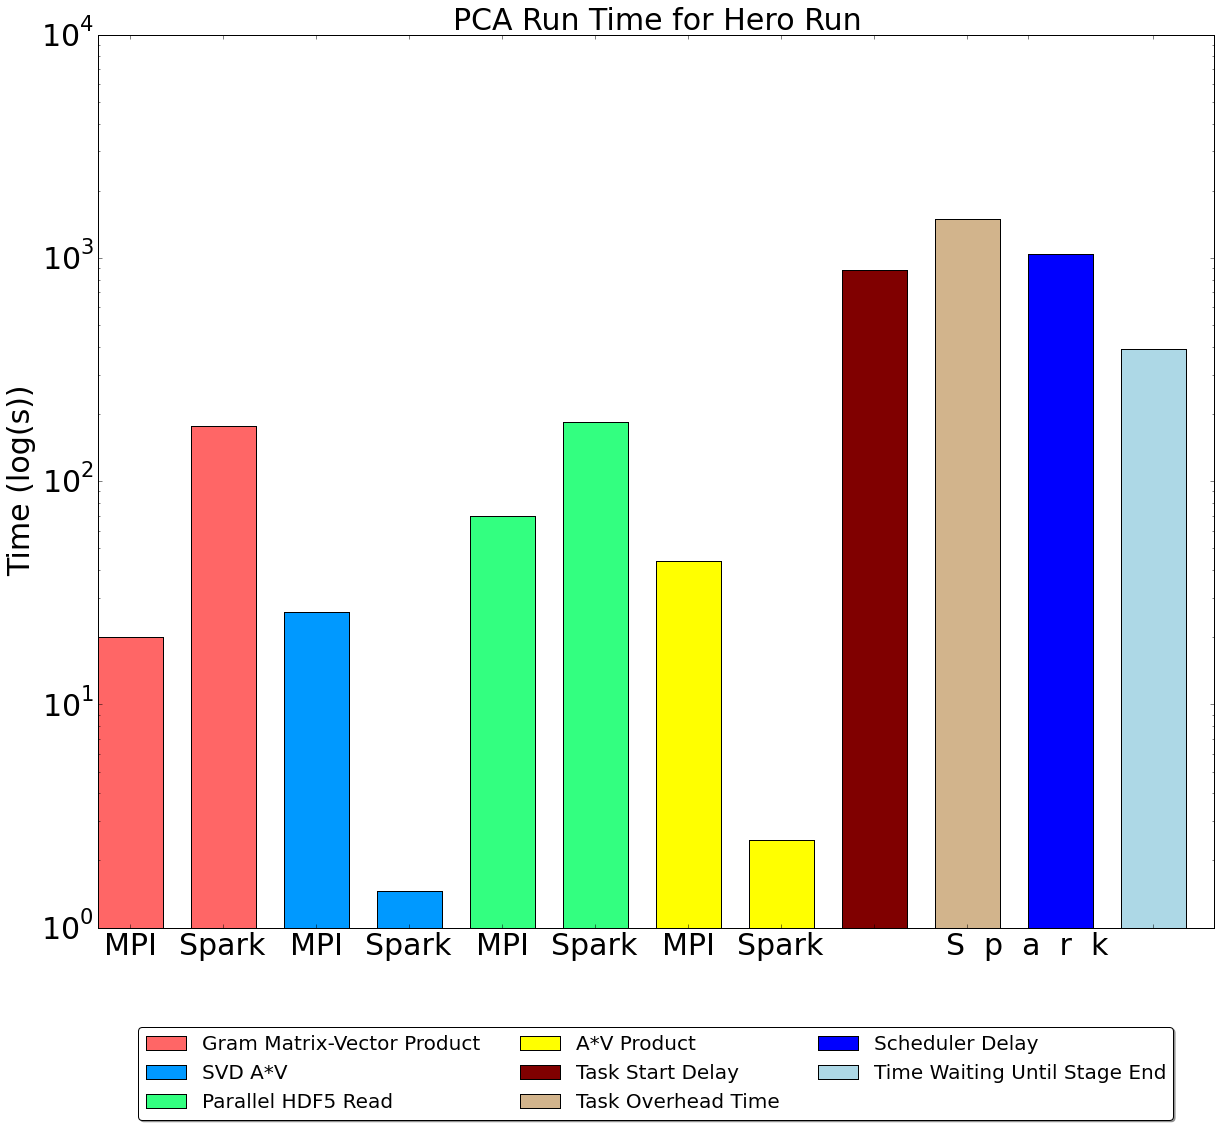

In [116]:
plt.rcParams['figure.figsize'] = (20.0, 16.0)
color_keys = color_key_dict[pd.algo]
bottom = len(items_to_plot[0].keys()) *[0]
bars = []
colors_ = colors.cnames.keys()
offset = 57
patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(len(bottom))
width = 0.7
label_table = {}
j =0
spark_mpi_inds = []
keys = mpi_times.keys() + summary_ordered_keys
for i,k in enumerate(keys):
    if k in label_table:
        continue
    if k in mpi_times and k in spark_times:
        color = colores[color_keys.index(k)]
        bar = ax1.bar(ind[j:j+2],(mpi_times[k], spark_times[k] / 1000.),
                            width=width,color=color,
                             ecolor='k',label=k)
        label_table[k] = 0
        spark_mpi_inds.extend(inds[j:j+2])
        j += 2
    elif k in spark_times:
        if k=="JVM GC Time":
            continue
        color = colors_dict[k]
        bar = ax1.bar(ind[j:j+1],spark_times[k] / 1000.,
                            width=width,color=color,
                             ecolor='k',label=k)
        label_table[k] = 0
        j += 1
        
#         if k not in : #or k == "Time Waiting Until Stage End":
#             continue
#         if k == "JVM GC Time":
#             print it[k] / 1000.
#             continue
      
#         if k in color_keys:
#             print k
#             color = colores[color_keys.index(k)]
#         else:
#             color = colors_[i+offset]
            
#         if k not in label_table:
#             label_table[k] = 0
#             label = k
#         else:
#             label = None
#         val = it[k]
#         #cur_values = np.asarray([c_mpl[k] / 1000. for c_mpl in [mins_for_mpl, medians_for_mpl, maxes_for_mpl]])
#         bar = ax1.bar(ind[j], val,
#                             width=width,color=color, bottom=bottom[j],
#                              ecolor='k',label=label)

#         bottom[j] = bottom[j] + val

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=True, ncol=3, prop={'size': 20})
plt.ylabel('Time (log(s))', fontsize=30)
#plt.xlabel('Nodes', fontsize=14)
#gc_times = ["GC: " + str(item["JVM GC Time"] / 1000. ) + " s" for item in items_to_plot]
#print gc_times
ax1.set_yscale('log')
plt.yticks(fontsize=30)
ticks =np.arange(j) + width /2
ticks[-2] -= width /2
plt.xticks(ticks,len(spark_mpi_inds) / 2 * ['MPI', "Spark"] + ["","","S  p  a  r  k", ""], fontsize=30)
plt.title("%s Run Time for Hero Run "% ( pds[0].algo.upper()), fontsize=30)
plt.show()

#Stage by Stage, Executor by Executor Spark Plots

In [274]:
pd = big_run_pd

In [220]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
plt.rcParams['figure.figsize'] = (40.0, 32.0)

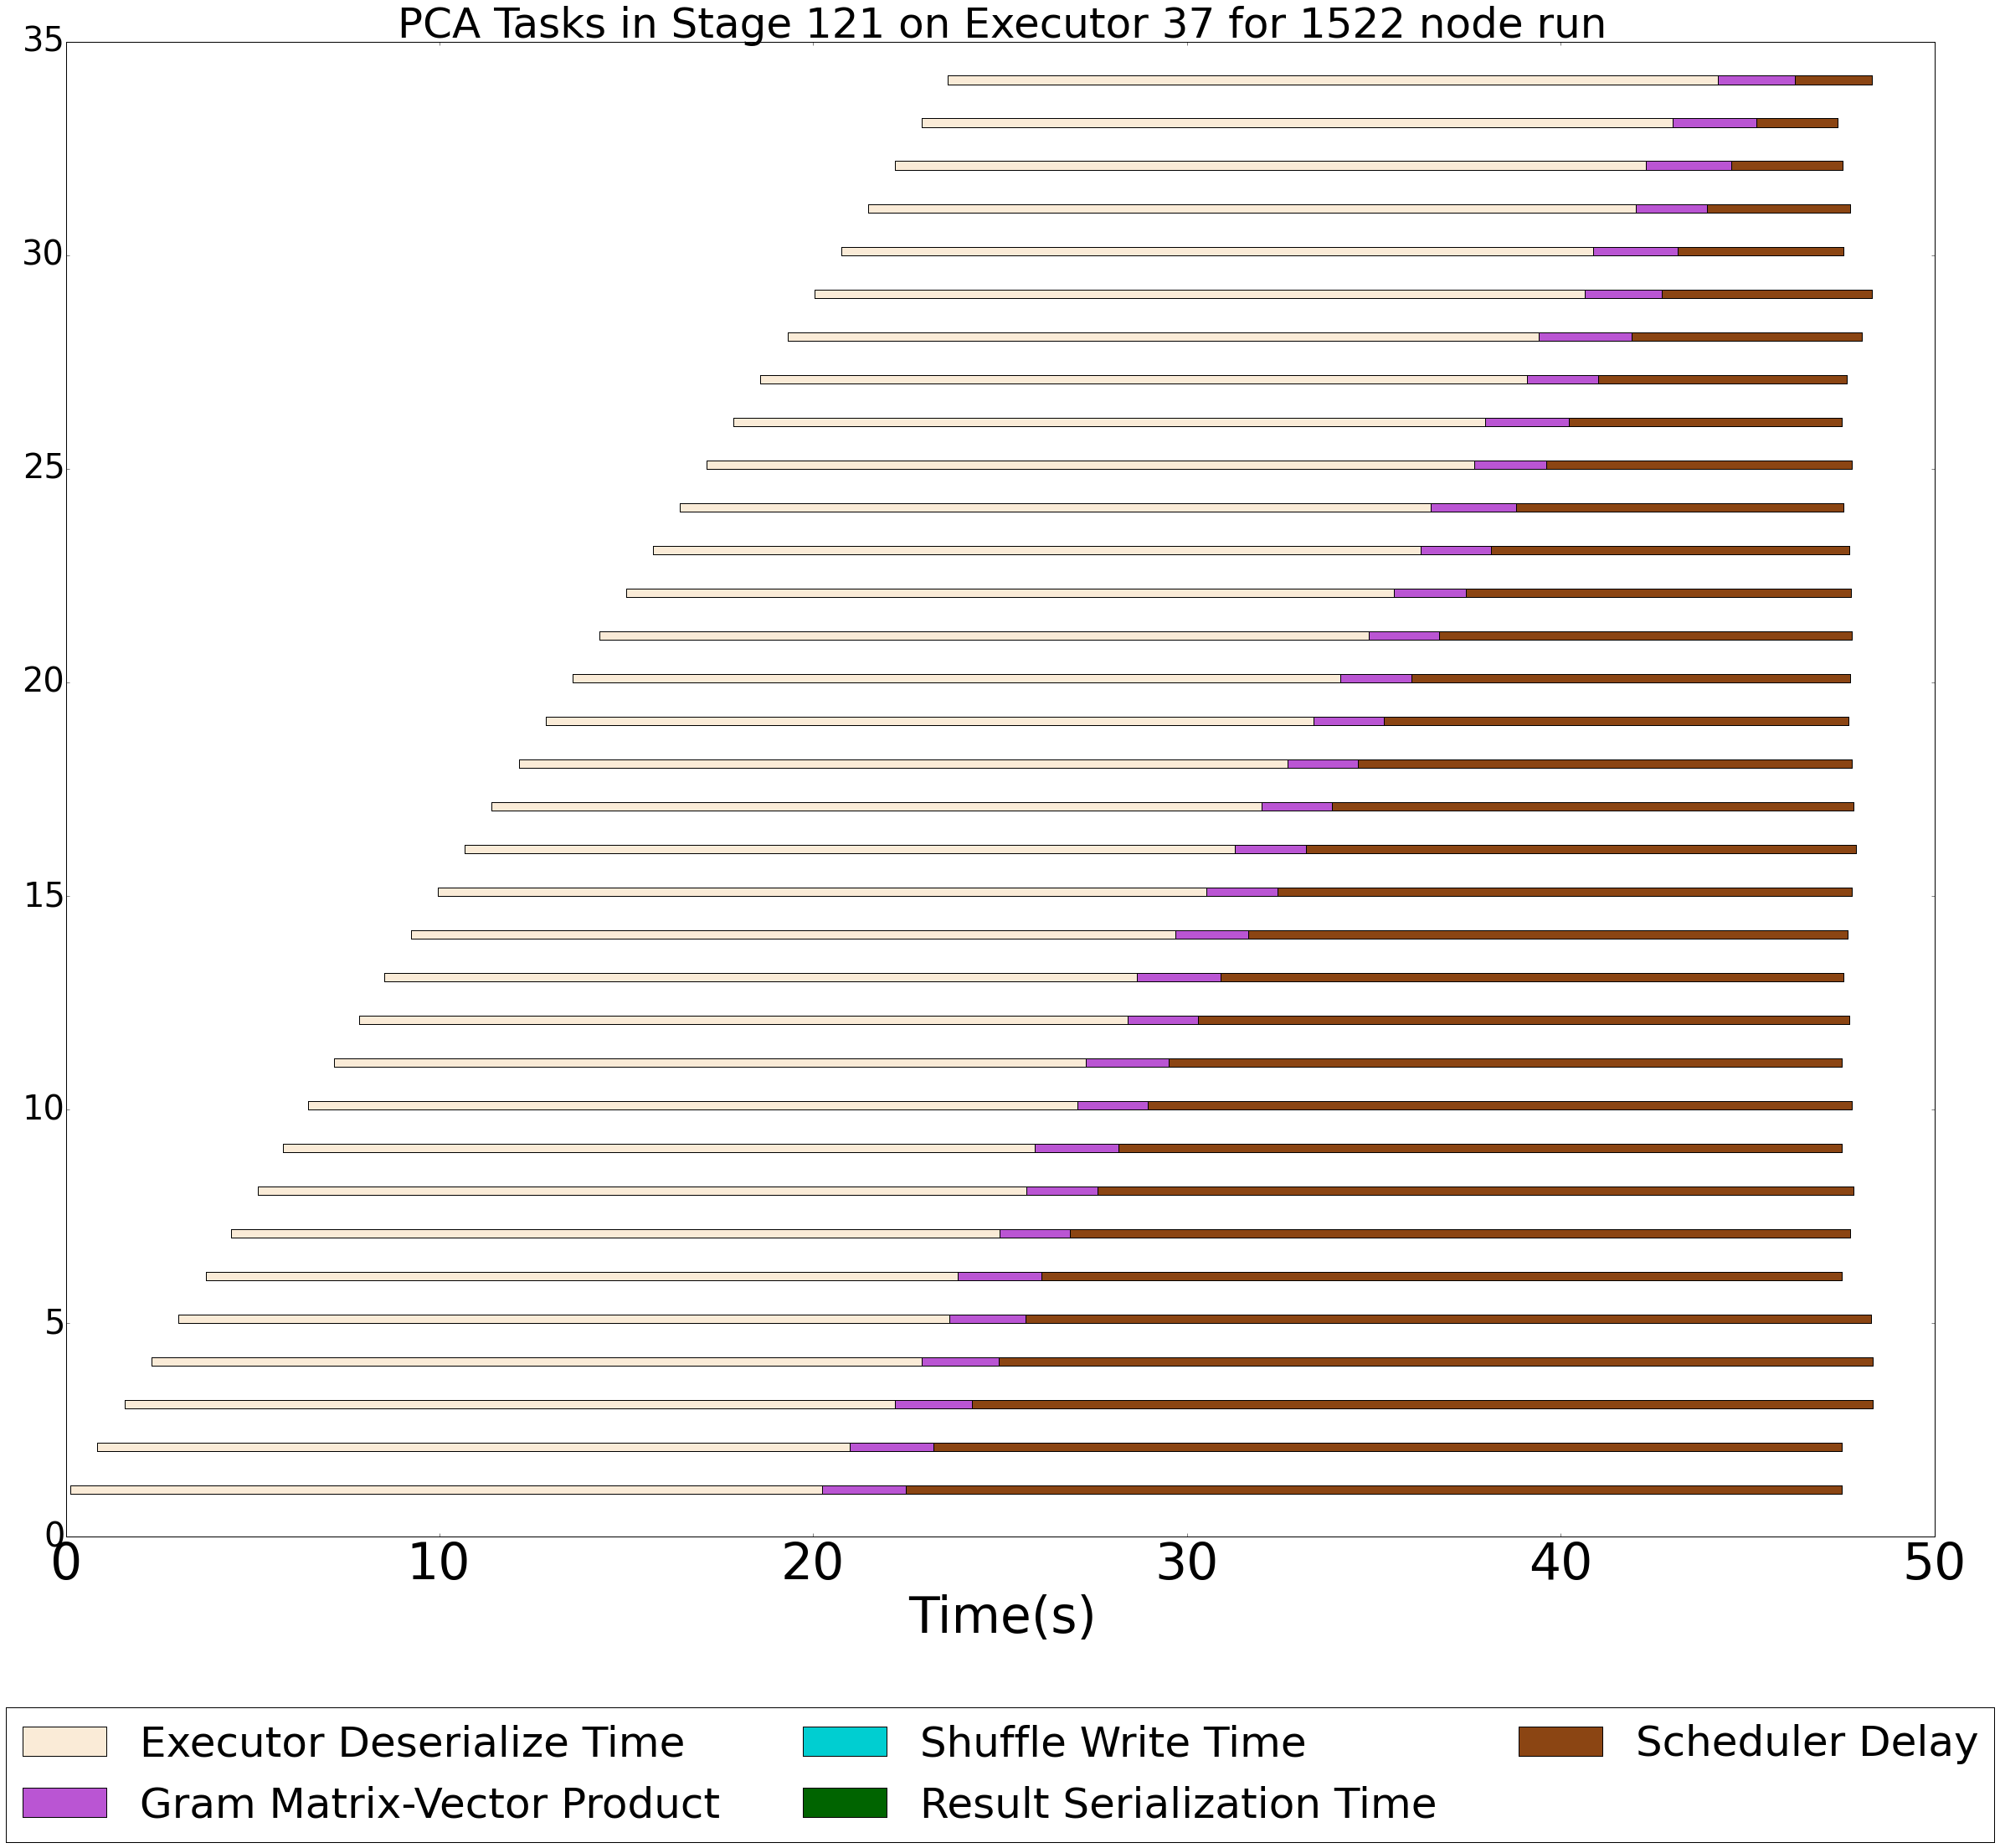

In [306]:
ex_stage_tasks1 = pd.stage_and_exec_keyed_task_info.filter(lambda ((stage,ex), d):stage in [121] and ex in [37])
ex_stage_tasks2 = pd.stage_and_exec_keyed_task_info.filter(lambda ((stage,ex), d): stage in [8] and ex in [37])
t_dict1,t_dict2 = (ex_stage_tasks1.map(lambda (i,v): v).collect(), ex_stage_tasks2.map(lambda (i,v): v).collect())
t_dict1.sort(lambda v1,v2: 1 if v1['Task Start Delay'] > v2['Task Start Delay'] else -1)
t_dict2.sort(lambda v1,v2: 1 if v1['Task Start Delay'] > v2['Task Start Delay'] else -1)
rds = t_dict1
left = len(rds)*[0]
bars = []
colors_ = colors.cnames.keys()
offset = 47
offset2=105
#patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(len(rds) + 1)
height = 0.2
#stage_barrier = 0.2
stage_begins = [0]
label_dict = {}


    
for m,rd in enumerate(rds):
        for i,k in enumerate(ordered_keys):
            if k not in rd:

                continue
            cur = rd[k] / 1000.
            if k not in label_dict:

                label = k
                label_dict[label] = 0
            else:
                label = None 
            if k in color_key_dict:
                color = color_key_dict['pca'][k]
            elif k in color_key_dict:
                color=colors_dict[k]
            else:
                color = colors_[offset+i]
            ecolor = 'k'
            if k == "Time Waiting Until Stage End" or k == "JVM GC Time":
                continue
            #cur_values = np.asarray([c_mpl[(stage,execu)][k] / 1000. for c_mpl in rds] )
            if  k != 'Task Start Delay':
                bar = ax1.barh(ind[m+1], cur,
                                height=height,color=color, left=left[m],
                                 ecolor=ecolor, label=label)

            left[m] = left[m] + cur
    #print left




ax1.legend( loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   ncol=3, prop={'size': 50})







ax1.set_xlabel('Time(s)', fontdict={'size':60})
plt.yticks(size=40)
plt.title("%s Tasks in Stage %s on Executor %s for %i node run"% (pd.algo.upper(), 121, 37, pd.num_execs), fontdict={'size': 50})
plt.xticks(size=60)
plt.show()

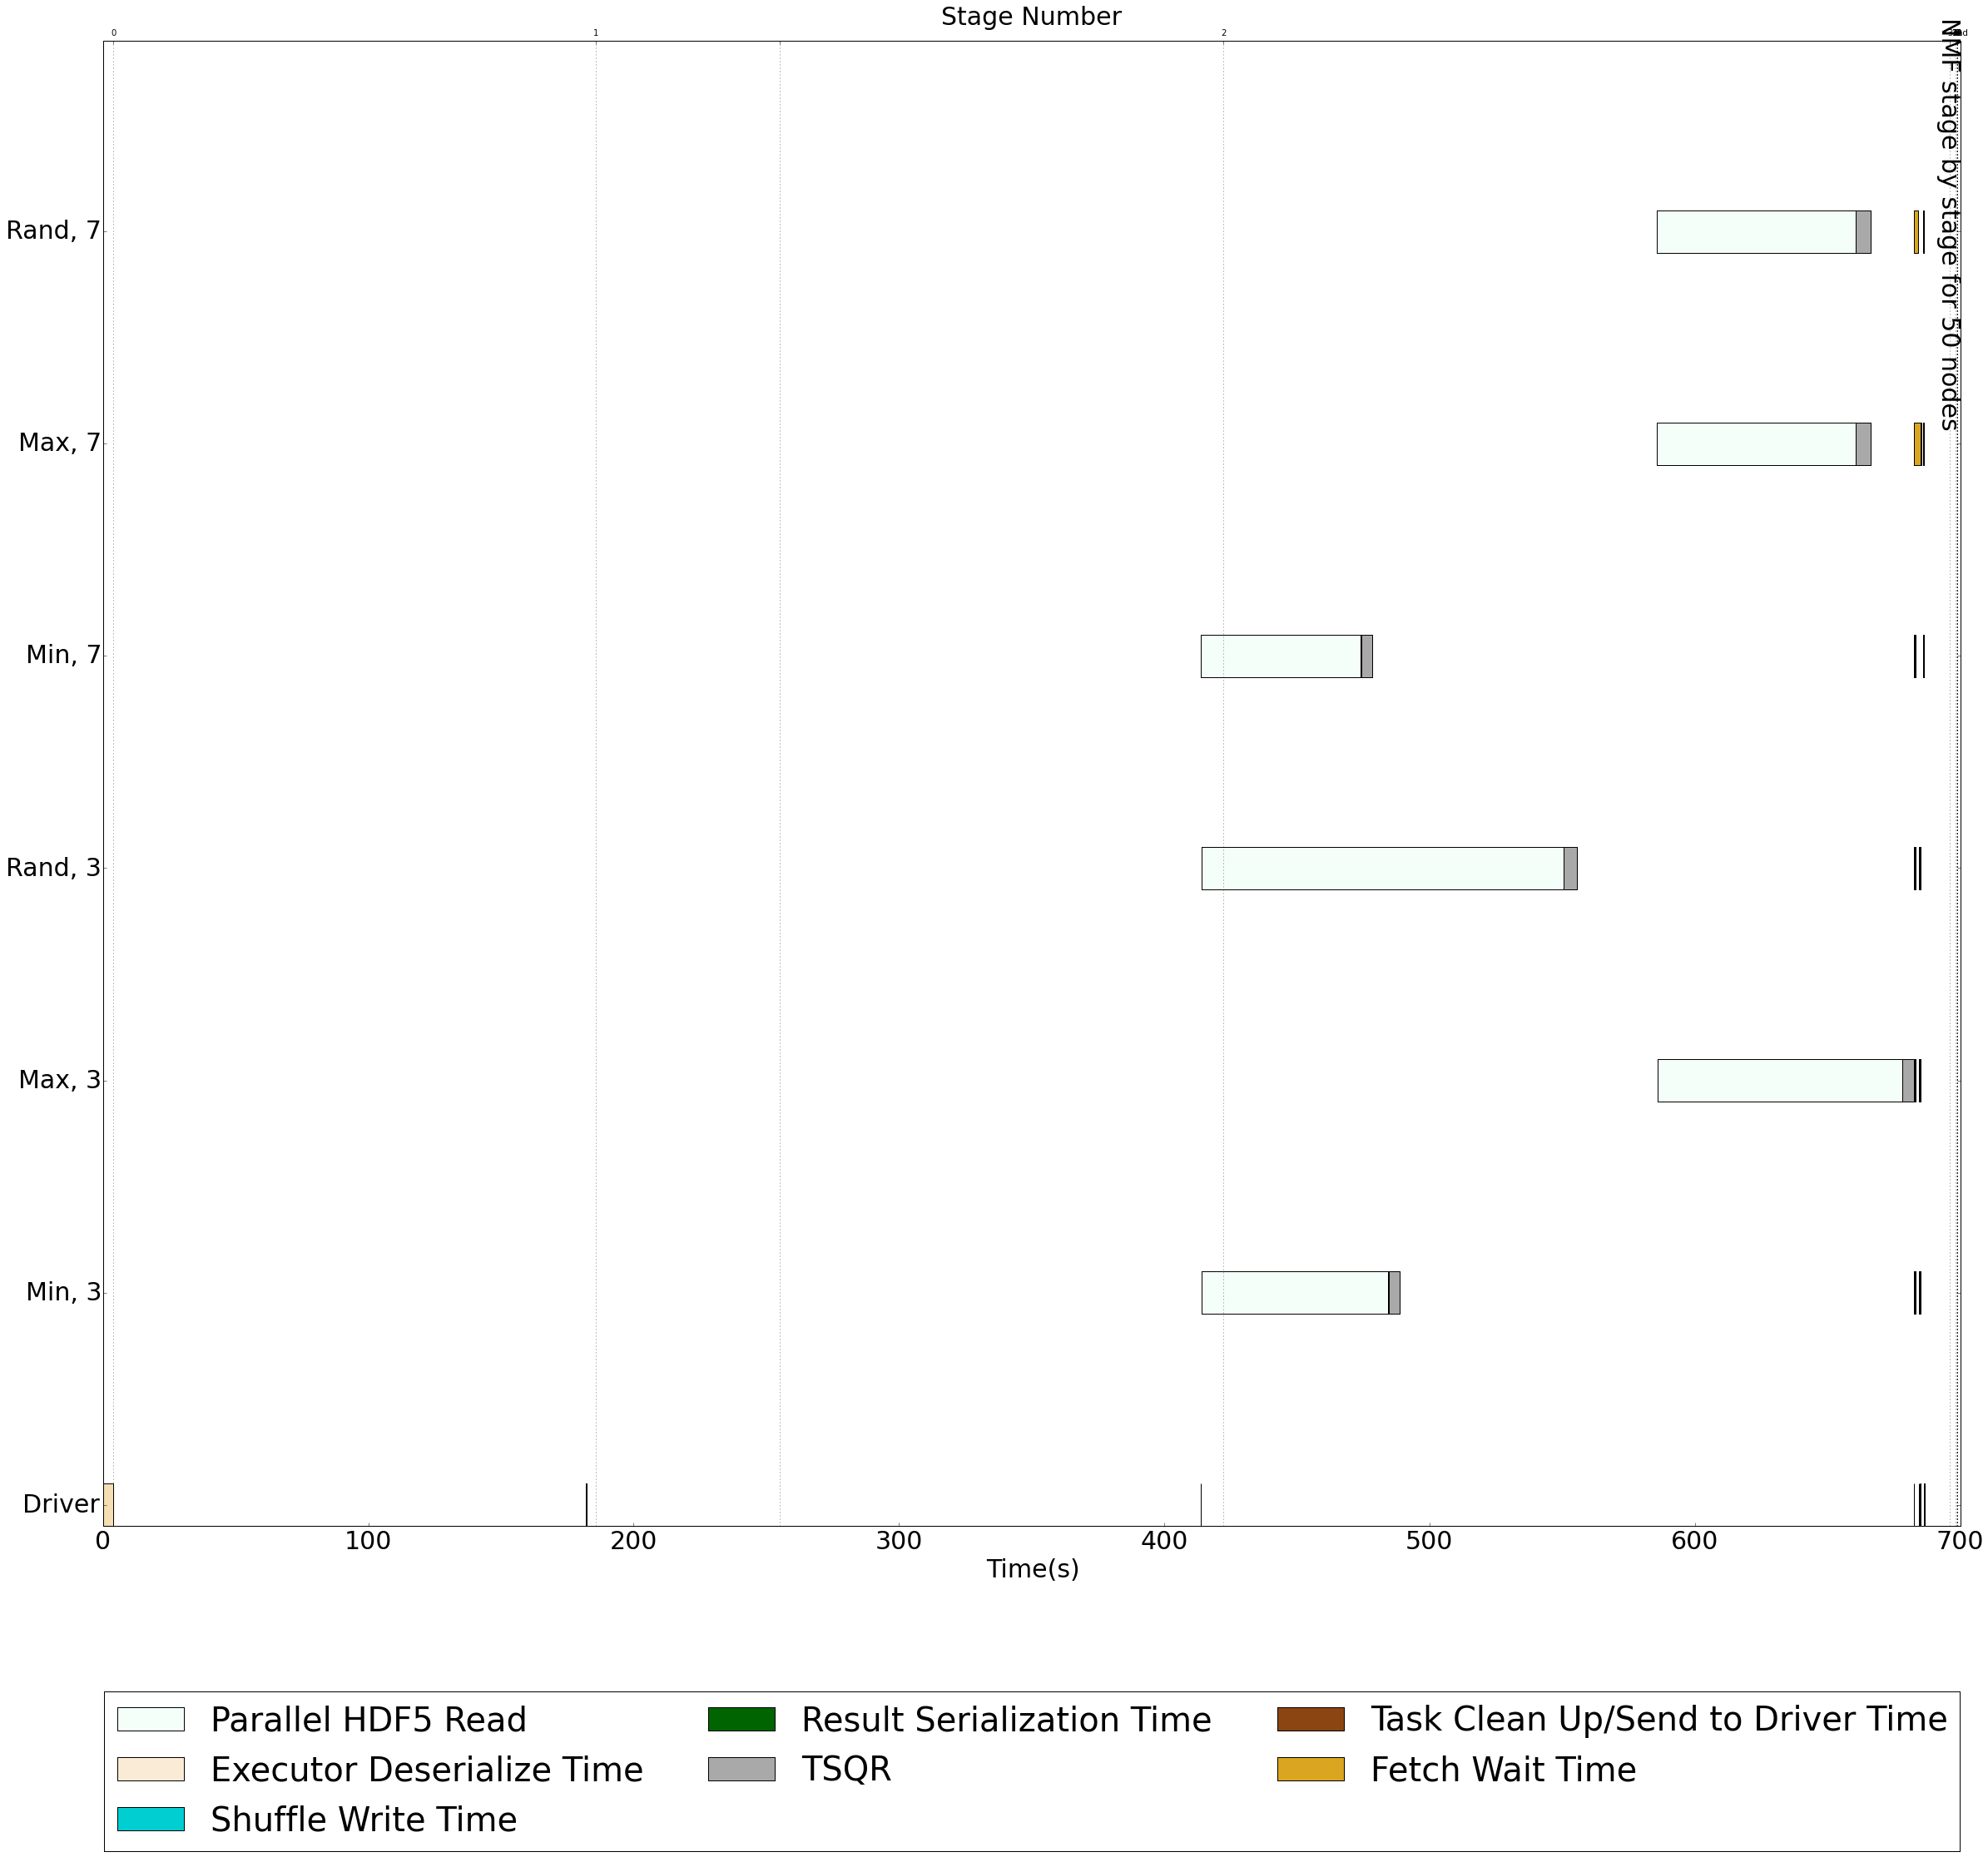

In [48]:
minr, maxr,randr = [pd.get_summary_tasks_for_each_executor(f, 'Time To Finish From Stage Start') 
              for f in ['min', 'max','rand']]
min1, max1, rand1 = [da_rdd.filter(lambda ((stage,execu), task): execu == 3).collectAsMap() for da_rdd in [minr, maxr, randr]]
min2, max2, rand2 = [da_rdd.filter(lambda ((stage,execu), task): execu == 7).collectAsMap() for da_rdd in [minr, maxr, randr]]
rds = (min1,max1,rand1,min2,max2,rand2)
left = tuple(len(rds)*[0])
bars = []
colors_ = colors.cnames.keys()
offset = 47
offset2=105
#patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(len(rds) + 1)
height = 0.2
#stage_barrier = 0.2
stage_begins = [0]
label_dict = {}

for stage,time in stage_times.iteritems():
    #make driver bar
    driv_comp_time = pd.driver_comp_dict[stage-1]/1000.
    cur_values = np.asarray( len(left)*[driv_comp_time])
    bar = ax1.barh((0), cur_values[0],
                            height=height,color=colors_[offset2+9], left=left[0],
                             ecolor='k')
    
    left = left + cur_values
    stage_begins.append(left[0])
    #print stage, len(stage_begins)

    
    for m,rd in enumerate(rds):
        execu = rd.keys()[0][1]
        if (stage,execu) not in rd:
            left[m] = left[m] + stage_times[stage] / 1000.
            #print stage,execu
            continue
        for i,k in enumerate(ordered_keys):
       

    
            cur_rd = rd[(stage,execu)]
            if k not in cur_rd:

                continue
            cur = cur_rd[k] / 1000.
            if k not in label_dict:

                label = k
                label_dict[label] = 0
            else:
                label = None 
            color=colors_[i+offset]
            ecolor = 'k'

            #cur_values = np.asarray([c_mpl[(stage,execu)][k] / 1000. for c_mpl in rds] )
            if k != "Time Waiting Until Stage End" and k != 'Task Start Delay':
                bar = ax1.barh(ind[m+1], cur,
                                height=height,color=color, left=left[m],
                                 ecolor=ecolor, label=label)

            left[m] = left[m] + cur
    #print left


cur_values = (pd.driver_comp_dict[stage] / 1000.)

bar = ax1.barh((0), cur_values,
                        height=height,color=colors_[offset2+9], left=left[0],
                         ecolor='k')

stage_begins.append(left[0])

ax1.legend()
ax1.legend( loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   ncol=3, prop={'size': 40})

ax2 = ax1.twiny()


stage_begins.append(250)
ax2.xaxis.set_ticks(stage_begins)


labels = [item.get_text() for item in ax2.get_xticklabels()]
#ax2.set_xticks?
labels[0] = ''
labels[1:len(stage_begins)] = list(range(len(stage_begins)))
labels[-2] = ''
labels[-3] = 'end'
ax2.set_xticklabels(labels)
ax2.grid(True)
ax2.set_xlabel('Stage Number', fontdict={'size':30})
ax1.set_xlabel('Time(s)', fontdict={'size':30})
plt.yticks(ind + height/2., ('Driver','Min, 3', 'Max, 3','Rand, 3', 'Min, 7', 'Max, 7', 'Rand, 7'))
plt.title("%s stage by stage for %i nodes"% (pd.algo.upper(), pd.num_execs), rotation=-90, loc='right', fontdict={'size': 30})
ax1.tick_params( which='major', labelsize=30)
ax2.tick_params(axis=ax1, which='minor', labelsize=30)
plt.show()

#Plot Summary Using Max/Min/Median **Bucket** (Task Category) in each Stage

In [10]:


minb, maxb, medianb, meanb = [pd.get_summary_buckets_for_mpl(f) for
                              f in ['min', 'max', 'median', 'mean']]
bottom = (0,0,0, 0)
bars = []
colors_ = colors.cnames.keys()
offset = 41
patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(4)
width = 0.2
for i,k in enumerate(ordered_keys):
    cur_values = np.asarray([c_mpl[k] / 1000. for c_mpl in [minb, medianb, meanb, maxb]])
    bar = ax1.bar(ind, cur_values,
                        width=width,color=colors_[i+offset], bottom=bottom,
                         ecolor='k')

    bottom = bottom + cur_values

ax1.legend(ordered_keys, loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=True, ncol=5, prop={'size': 10})
plt.ylabel('Time(s)')
plt.xticks(ind + width/2., ('Min', 'Median','Mean', 'Max'))
plt.title("%s at %s buckets"% (algo_name, event_log.split('benchmarks/')[1]))
plt.show()
summary_buckets= {pd.num_execs: pd.get_summary_buckets_for_mpl('max') for pd in pds}
bucket_sums = {num: sum([v for k,v in val.iteritems() if k[1] == "Task Start Delay"]) for num,val in summary_buckets.iteritems()}

bucket_maxes = {num: max([v for k,v in val.iteritems() if k[1] == "Task Start Delay"]) for num,val in summary_buckets.iteritems()}
buckets = {num: [v for k,v in val.iteritems() if k[1] == "Task Start Delay"] for num,val in summary_buckets.iteritems()}


#Box and Whisker Plot For Task Compute End Stuff and Task Start Delay

Gram Matrix-Vector Product


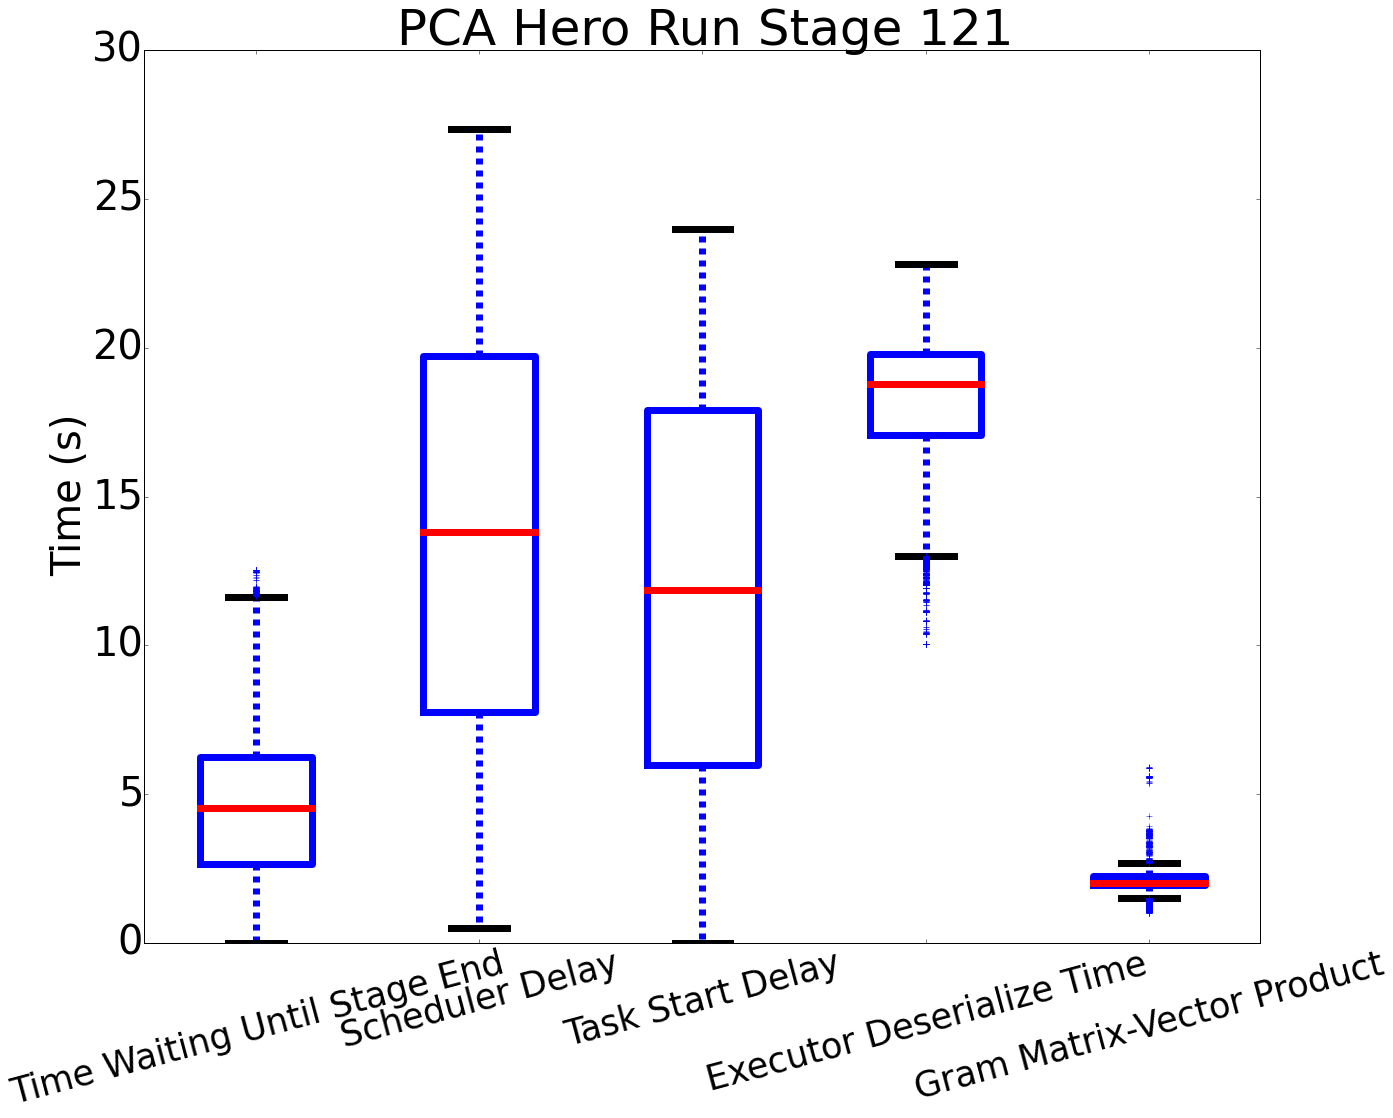

In [30]:
whisker_buckets=['Time Waiting Until Stage End', "Scheduler Delay", "Task Start Delay",
                 "Executor Deserialize Time","Gram Matrix-Vector Product", ]
task_dicts = {key: pd.stage_keyed_task_info.filter(lambda (stage,d): stage==121).filter(lambda (i,v): key in v).map(lambda (i,v): (i,v[key] / 1000.))\
.groupByKey().map(lambda (i,v): (i,list(v)))\
.collectAsMap() for key in whisker_buckets }
stage=121
plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.clf()
inds = np.arange(len(whisker_buckets)) + 1
#for i,k in enumerate(whisker_buckets):
print k
#plt.figure(i)
#if task_dicts[k] == {}:
#    continue
vals = [task_dicts[k][121] for k in whisker_buckets]

box=plt.boxplot(vals)

bplot_keys = ['boxes', 'whiskers', 'caps','fliers', 'medians']
for key in bplot_keys:
    for value in box[key]:
        value.set(linewidth=7)
plt.xticks(inds,whisker_buckets, fontsize=35, rotation=15)
plt.yticks(fontsize=40)
plt.ylabel('Time (s)', fontsize=40)
plt.title('PCA Hero Run Stage %s' % (stage), fontsize=50)
plt.show()